# Breakfast Dataset - Variant Experiment

This notebook runs experiments on the Breakfast dataset by controlling which trace variants are used for training and testing.

## Notebook Structure

1. **Setup & Data Loading** - Load dataset and analyze variants
2. **Hyperparameter Search** - Fixed train/test split, sweep over alpha and interpolation strategies
3. **Final Experiment** - Fixed hyperparameters, sweep over number of training cases

## 1. Setup

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import os
import logging
import random
import math
from pathlib import Path
from typing import List

import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# Setup workspace path
workspace_root = '/home/dsi/eli-bogdanov/sktr_for_long_traces'
if workspace_root not in sys.path:
    sys.path.insert(0, workspace_root)

from src.utils import (
    prepare_df, linear_prob_combiner,
    get_variant_info, select_variants, get_cases_for_variants, get_variants_for_cases
)
from src.incremental_softmax_recovery import incremental_softmax_recovery
from src.evaluation import compute_sktr_vs_argmax_metrics

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', force=True)
for mod in ['src.classes', 'src.incremental_softmax_recovery', 'src.utils', 'src.conformance_checking', 'src.data_processing', 'src.petri_model', 'src.calibration']:
    logging.getLogger(mod).setLevel(logging.DEBUG)
for mod in ['graphviz', 'matplotlib', 'PIL']:
    logging.getLogger(mod).setLevel(logging.WARNING)

print(f"Workspace: {workspace_root}")
print(f"Running in tmux: {'TMUX' in os.environ}")

Workspace: /home/dsi/eli-bogdanov/sktr_for_long_traces
Running in tmux: False


## 2. Configuration

In [ ]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# --- Case Selection ---
# List of case IDs to use for experiments (order is preserved for sweep)
CASE_IDS = [649, 357, 542, 834, 1006, 385, 243, 553, 386, 48, 841, 877, 321, 226, 670]

# --- General ---
RANDOM_SEED = 42

# --- Parallelization ---
N_PARALLEL_RUNS = 5  # Number of experiment runs to execute in parallel
DATASET_PARALLELIZATION = True  # Enable parallel processing of test cases
N_DATASET_WORKERS = 8  # Workers per run for dataset parallelization

# --- Output ---
SAVE_PROCESS_MODELS = True  # Save discovered Petri net

## 3. Load Dataset

In [3]:
dataset_name = 'breakfast'

result = prepare_df(dataset_name)
df, softmax_lst = result[:2]

print(f"Dataset: {dataset_name}")
print(f"  Events: {len(df):,}")
print(f"  Cases: {df['case:concept:name'].nunique()}")
print(f"  Activities: {df['concept:name'].nunique()}")

Dataset: breakfast
  Events: 2,021,688
  Cases: 1008
  Activities: 45


## 4. Prepare Case Data

Validate case IDs and build case-to-variant mapping.

In [ ]:
def get_variant_info(df: pd.DataFrame) -> pd.DataFrame:
    """Analyze trace variants. Returns DataFrame sorted by frequency (variant_id 0 = most frequent)."""
    trace_variants = {}
    for case_id in df['case:concept:name'].unique():
        trace = tuple(df[df['case:concept:name'] == case_id]['concept:name'].tolist())
        if trace not in trace_variants:
            trace_variants[trace] = {'case_ids': [], 'length': len(trace)}
        trace_variants[trace]['case_ids'].append(case_id)
    
    data = [{'variant_id': i, 'trace_signature': sig, 'case_ids': info['case_ids'],
             'frequency': len(info['case_ids']), 'trace_length': info['length']}
            for i, (sig, info) in enumerate(trace_variants.items())]
    
    variant_df = pd.DataFrame(data).sort_values('frequency', ascending=False).reset_index(drop=True)
    variant_df['variant_id'] = range(len(variant_df))
    return variant_df


def get_cases_for_variants(variant_df: pd.DataFrame, variant_ids: List[int], seed: int = 42) -> List[str]:
    """Get all case IDs for the specified variants."""
    cases = []
    for vid in variant_ids:
        row = variant_df[variant_df['variant_id'] == vid]
        if not row.empty:
            cases.extend(row.iloc[0]['case_ids'])
    return cases


variant_df = get_variant_info(df)
print(f"Total variants in dataset: {len(variant_df)}")

In [ ]:
# Validate case IDs and build mappings
case_ids_str = [str(cid) for cid in CASE_IDS]

available_cases = df['case:concept:name'].unique().astype(str).tolist()
missing_cases = [cid for cid in case_ids_str if cid not in available_cases]
if missing_cases:
    print(f"Warning: {len(missing_cases)} case IDs not found: {missing_cases[:10]}...")
    case_ids_str = [cid for cid in case_ids_str if cid in available_cases]
    print(f"Using {len(case_ids_str)} valid case IDs")

# Build case_id -> variant_id mapping
case_to_variant = {}
for _, row in variant_df.iterrows():
    for cid in row['case_ids']:
        case_to_variant[str(cid)] = row['variant_id']

# Get variants in list order
experiment_variants = []
seen_variants = set()
for cid in case_ids_str:
    vid = case_to_variant.get(cid)
    if vid is not None and vid not in seen_variants:
        experiment_variants.append(vid)
        seen_variants.add(vid)

# Setup results directory
results_dir = Path(workspace_root) / 'results' / dataset_name / 'variant_experiment'
results_dir.mkdir(parents=True, exist_ok=True)

print(f"Case IDs: {len(case_ids_str)} cases")
print(f"Unique variants: {len(experiment_variants)} -> {experiment_variants}")
print(f"\nCase ID -> Variant mapping:")
for cid in case_ids_str:
    vid = case_to_variant.get(cid, '?')
    print(f"  {cid} -> variant {vid}")

## 5. Helper Functions

In [ ]:
def build_base_config() -> dict:
    """Build base configuration for experiments."""
    return {
        'n_train_traces': None, 'n_test_traces': None,
        'train_cases': None, 'test_cases': None,
        'ensure_train_variant_diversity': False, 'ensure_test_variant_diversity': False,
        'use_same_traces_for_train_test': False, 'allow_train_cases_in_test': True,
        'compute_marking_transition_map': False, 'sequential_sampling': True,
        'n_indices': None, 'n_per_run': 10000, 'independent_sampling': True,
        'prob_threshold': 1e-6, 'chunk_size': 11, 'conformance_switch_penalty_weight': 1.0,
        'merge_mismatched_boundaries': False, 'conditioning_combine_fn': linear_prob_combiner,
        'max_hist_len': 3, 'conditioning_n_prev_labels': 3, 'use_collapsed_runs': True,
        'cost_function': 'linear', 'model_move_cost': 1.0, 'log_move_cost': 1.0,
        'tau_move_cost': 0.0, 'non_sync_penalty': 1.0,
        'use_calibration': True, 'temp_bounds': (1.0, 10.0), 'temperature': None,
        'verbose': True, 'log_level': logging.INFO, 'round_precision': 2,
        'random_seed': RANDOM_SEED,
        'save_model_path': None,
        'save_model': False,
        'parallel_processing': False,
        'dataset_parallelization': DATASET_PARALLELIZATION,
        'max_workers': N_DATASET_WORKERS,
    }


def run_single_experiment(train_cases, test_cases, alpha, strategy, weights,
                          idx, total, df, softmax_lst, base_cfg, results_dir, prefix):
    """Run a single experiment and return metrics."""
    print(f"[{idx}/{total}] train={len(train_cases)}, test={len(test_cases)}, alpha={alpha}, strategy={strategy}")
    
    cfg = base_cfg.copy()
    cfg.update({
        'conditioning_alpha': alpha, 
        'conditioning_interpolation_weights': weights,
        'train_cases': train_cases, 
        'test_cases': test_cases,
        'n_train_traces': len(train_cases), 
        'n_test_traces': len(test_cases),
        'save_model': SAVE_PROCESS_MODELS,
        'save_model_path': str(results_dir / f'petri_net_{prefix}'),
    })
    
    results_df, _, _ = incremental_softmax_recovery(df=df, softmax_lst=softmax_lst, **cfg)
    
    csv_path = results_dir / f"{dataset_name}_{prefix}_alpha_{alpha}_weights_{strategy}.csv"
    results_df.to_csv(csv_path, index=False)
    
    metrics = compute_sktr_vs_argmax_metrics(
        str(csv_path), 'case:concept:name', 'sktr_activity', 'argmax_activity', 'ground_truth', 0
    )
    
    return {
        'n_train_cases': len(train_cases), 'n_test_cases': len(test_cases),
        'alpha': alpha, 'strategy': strategy,
        'sktr_acc': metrics['sktr']['acc_micro'], 'sktr_edit': metrics['sktr']['edit'],
        'sktr_f1@10': metrics['sktr']['f1@10'], 'sktr_f1@25': metrics['sktr']['f1@25'], 'sktr_f1@50': metrics['sktr']['f1@50'],
        'argmax_acc': metrics['argmax']['acc_micro'], 'argmax_edit': metrics['argmax']['edit'],
        'argmax_f1@10': metrics['argmax']['f1@10'], 'argmax_f1@25': metrics['argmax']['f1@25'], 'argmax_f1@50': metrics['argmax']['f1@50'],
    }

In [ ]:
base_config = build_base_config()
print("Base config ready.")

---

# Part A: Hyperparameter Search

Fixed train/test split, sweep over all alpha and interpolation strategy combinations to find optimal hyperparameters.

In [ ]:
# =============================================================================
# HYPERPARAMETER SEARCH CONFIGURATION
# =============================================================================

# Train/test split for hyperparameter search (use all cases for both)
HP_TRAIN_CASES = case_ids_str  # All cases for training
HP_TEST_CASES = case_ids_str   # All cases for testing

# Hyperparameter grid to search
HP_ALPHAS = [0.01, 0.05, 0.1, 0.2]
HP_STRATEGIES = {
    'unigram_super_heavy': [0.75, 0.15, 0.1],
    'balanced': [0.33, 0.33, 0.34],
    'bigram_heavy': [0.2, 0.6, 0.2],
}

print(f"Hyperparameter Search Setup:")
print(f"  Train cases: {len(HP_TRAIN_CASES)}")
print(f"  Test cases: {len(HP_TEST_CASES)}")
print(f"  Alphas: {HP_ALPHAS}")
print(f"  Strategies: {list(HP_STRATEGIES.keys())}")
print(f"  Total experiments: {len(HP_ALPHAS) * len(HP_STRATEGIES)}")

In [ ]:
# Run hyperparameter search
hp_results_dir = results_dir / 'hyperparameter_search'
hp_results_dir.mkdir(parents=True, exist_ok=True)

hp_params = [(HP_TRAIN_CASES, HP_TEST_CASES, a, s, w)
             for a in HP_ALPHAS
             for s, w in HP_STRATEGIES.items()]

n_jobs = N_PARALLEL_RUNS if N_PARALLEL_RUNS is not None else -1

print(f"Running {len(hp_params)} hyperparameter experiments...")
print("=" * 60)

hp_results = Parallel(n_jobs=n_jobs, verbose=10)(
    delayed(run_single_experiment)(
        train, test, alpha, strategy, weights,
        i, len(hp_params), df, softmax_lst, base_config, hp_results_dir, f"hp_search"
    )
    for i, (train, test, alpha, strategy, weights) in enumerate(hp_params, 1)
)

hp_summary_df = pd.DataFrame(hp_results).sort_values('sktr_acc', ascending=False)
hp_summary_path = hp_results_dir / f"{dataset_name}_hp_search_summary.csv"
hp_summary_df.to_csv(hp_summary_path, index=False)
print(f"\nSaved: {hp_summary_path}")

### Hyperparameter Search Results

In [ ]:
# Display hyperparameter search results (sorted by SKTR accuracy)
print("Hyperparameter Search Results (sorted by SKTR accuracy):\n")
display(hp_summary_df[['alpha', 'strategy', 'sktr_acc', 'argmax_acc', 'sktr_edit', 'argmax_edit', 'sktr_f1@25', 'argmax_f1@25']])

# Best hyperparameters
best_hp = hp_summary_df.iloc[0]
print(f"\nBest hyperparameters:")
print(f"  Alpha: {best_hp['alpha']}")
print(f"  Strategy: {best_hp['strategy']}")
print(f"  SKTR Accuracy: {best_hp['sktr_acc']:.4f}")
print(f"  SKTR Edit: {best_hp['sktr_edit']:.4f}")

In [ ]:
# Visualize hyperparameter search results
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

plot_cols = ['sktr_acc', 'sktr_edit', 'sktr_f1@25']
y_min = hp_summary_df[plot_cols].min().min()
y_max = hp_summary_df[plot_cols].max().max()
y_lower = math.floor(y_min / 10) * 10
y_max = max(y_max, 80)
tick_start = y_lower
tick_end = math.ceil(y_max / 10) * 10
y_limits = (tick_start, tick_end)
y_ticks = list(range(int(tick_start), int(tick_end) + 1, 10))

for ax, metric in zip(axes, plot_cols):
    pivot = hp_summary_df.pivot(index='alpha', columns='strategy', values=metric)
    pivot.plot(kind='bar', ax=ax, rot=0)
    ax.set_xlabel('Alpha')
    ax.set_ylabel(metric.replace('sktr_', '').replace('_', ' ').title())
    ax.set_title(f'SKTR {metric.replace("sktr_", "").replace("_", " ").title()}')
    ax.legend(title='Strategy', fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')
    if y_limits is not None:
        ax.set_ylim(*y_limits)
    if y_ticks is not None:
        ax.set_yticks(y_ticks)

plt.suptitle('Hyperparameter Search Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(hp_results_dir / f'{dataset_name}_hp_search_plots.png', dpi=150)
plt.show()

---

# Part B: Final Experiment (Training Sweep)

Use the best hyperparameters from Part A and sweep over number of training cases to study the effect of training data size.

In [ ]:
# =============================================================================
# FINAL EXPERIMENT CONFIGURATION
# =============================================================================

# Option 1: Use best hyperparameters from search (uncomment to use)
# FINAL_ALPHA = best_hp['alpha']
# FINAL_STRATEGY = best_hp['strategy']
# FINAL_WEIGHTS = HP_STRATEGIES[best_hp['strategy']]

# Option 2: Manually specify hyperparameters
FINAL_ALPHA = 0.05
FINAL_STRATEGY = 'unigram_super_heavy'
FINAL_WEIGHTS = [0.75, 0.15, 0.1]

# Training sweep configuration
SWEEP_STEP = 1  # Step size: 1 = all values (1,2,3,...,N), 5 = every 5th (1,6,11,...)
SWEEP_START = 1  # Starting number of training cases

# Test set (always all cases)
FINAL_TEST_CASES = case_ids_str

# Generate training sweep values
n_total = len(case_ids_str)
sweep_values = list(range(SWEEP_START, n_total + 1, SWEEP_STEP))
if n_total not in sweep_values:  # Always include the final value
    sweep_values.append(n_total)

print(f"Final Experiment Configuration:")
print(f"  Alpha: {FINAL_ALPHA}")
print(f"  Strategy: {FINAL_STRATEGY}")
print(f"  Weights: {FINAL_WEIGHTS}")
print(f"  Test cases: {len(FINAL_TEST_CASES)} (all)")
print(f"  Training sweep: {sweep_values}")
print(f"  Total experiments: {len(sweep_values)}")

In [ ]:
# Build training configurations for sweep
sweep_configs = {}
for n in sweep_values:
    train_case_ids = case_ids_str[:n]
    # Find which variants these cases belong to
    train_variant_ids = []
    seen = set()
    for cid in train_case_ids:
        vid = case_to_variant.get(cid)
        if vid is not None and vid not in seen:
            train_variant_ids.append(vid)
            seen.add(vid)
    sweep_configs[n] = {
        'variant_ids': train_variant_ids,
        'case_ids': train_case_ids
    }

print("Training Sweep Progression:")
for n, cfg in sweep_configs.items():
    cases_str = str(cfg['case_ids']) if len(cfg['case_ids']) <= 5 else f"{cfg['case_ids'][:3]}...{cfg['case_ids'][-1]}"
    print(f"  n={n:2d} -> {len(cfg['case_ids']):2d} case(s), {len(cfg['variant_ids']):2d} variant(s)  cases={cases_str}")

In [ ]:
# Run final experiment sweep
final_results_dir = results_dir / 'final_experiment'
final_results_dir.mkdir(parents=True, exist_ok=True)

sweep_params = [(cfg['case_ids'], FINAL_TEST_CASES, FINAL_ALPHA, FINAL_STRATEGY, FINAL_WEIGHTS, n)
                for n, cfg in sweep_configs.items()]

print(f"Running {len(sweep_params)} sweep experiments...")
print("=" * 60)

sweep_results = Parallel(n_jobs=n_jobs, verbose=10)(
    delayed(run_single_experiment)(
        train, test, alpha, strategy, weights,
        i, len(sweep_params), df, softmax_lst, base_config, final_results_dir, f"sweep_n{n}"
    )
    for i, (train, test, alpha, strategy, weights, n) in enumerate(sweep_params, 1)
)

# Add n_train to results and variant info
for i, (n, cfg) in enumerate(sweep_configs.items()):
    sweep_results[i]['n_train'] = n
    sweep_results[i]['n_variants'] = len(cfg['variant_ids'])

sweep_summary_df = pd.DataFrame(sweep_results).sort_values('n_train')
sweep_summary_path = final_results_dir / f"{dataset_name}_sweep_summary.csv"
sweep_summary_df.to_csv(sweep_summary_path, index=False)
print(f"\nSaved: {sweep_summary_path}")

### Final Experiment Results

In [3]:
from pathlib import Path
import pandas as pd

workspace_root = globals().get('workspace_root', '/home/dsi/eli-bogdanov/sktr_for_long_traces')
dataset_name = globals().get('dataset_name', 'breakfast')

results_dir = Path(workspace_root) / 'results' / dataset_name / 'variant_experiment'
final_results_dir = results_dir / 'final_experiment'
sweep_summary_path = final_results_dir / f"{dataset_name}_sweep_summary.csv"

if not sweep_summary_path.exists():
    raise FileNotFoundError(f"Missing sweep summary CSV: {sweep_summary_path}")

sweep_summary_df = pd.read_csv(sweep_summary_path).sort_values('n_train').reset_index(drop=True)
print(f"Loaded sweep summary: {sweep_summary_path}")


Loaded sweep summary: /home/dsi/eli-bogdanov/sktr_for_long_traces/results/breakfast/variant_experiment/final_experiment/breakfast_sweep_summary.csv


In [4]:
# Display sweep results
print("Training Sweep Results:\n")
display(sweep_summary_df[['n_train', 'n_variants', 'sktr_acc', 'argmax_acc', 'sktr_edit', 'argmax_edit', 'sktr_f1@25', 'argmax_f1@25']])

Training Sweep Results:



,n_train,n_variants,sktr_acc,argmax_acc,sktr_edit,argmax_edit,sktr_f1@25,argmax_f1@25
0,1,1,55.149977,75.542224,34.284411,55.345349,32.757941,62.807875
1,2,2,65.625288,75.542224,48.600718,55.345349,51.578369,62.807875
2,3,3,65.486848,75.542224,45.509607,55.345349,51.732348,62.807875
3,4,4,67.245039,75.542224,50.083367,55.345349,60.834912,62.807875
4,5,5,64.185510,75.542224,56.885865,55.345349,63.227041,62.807875
5,6,6,73.174896,75.542224,63.650794,55.345349,70.127051,62.807875
6,7,7,75.989848,75.542224,65.617914,55.345349,72.873649,62.807875
7,8,8,75.800646,75.542224,64.980159,55.345349,71.575438,62.807875
8,9,9,75.749885,75.542224,64.980159,55.345349,71.575438,62.807875
9,10,10,75.989848,75.542224,67.956349,55.345349,74.262513,62.807875


In [6]:
# Improvement analysis
analysis = sweep_summary_df.copy()
analysis['acc_gain'] = analysis['sktr_acc'] - analysis['argmax_acc']
analysis['edit_gain'] = analysis['sktr_edit'] - analysis['argmax_edit']
analysis['f1@25_gain'] = analysis['sktr_f1@25'] - analysis['argmax_f1@25']

print("SKTR Improvement over Argmax:")
print(f"  Accuracy:  mean={analysis['acc_gain'].mean():+.4f}, max={analysis['acc_gain'].max():+.4f}")
print(f"  Edit:      mean={analysis['edit_gain'].mean():+.4f}, max={analysis['edit_gain'].max():+.4f}")
print(f"  F1@25:     mean={analysis['f1@25_gain'].mean():+.4f}, max={analysis['f1@25_gain'].max():+.4f}")

best_idx = analysis['sktr_acc'].idxmax()
print(f"\nBest SKTR accuracy: {analysis.loc[best_idx, 'sktr_acc']:.4f} at n_train={analysis.loc[best_idx, 'n_train']}")

SKTR Improvement over Argmax:
  Accuracy:  mean=-4.1654, max=+0.7383
  Edit:      mean=+4.1678, max=+12.6110
  F1@25:     mean=+2.8418, max=+11.9548

Best SKTR accuracy: 76.2806 at n_train=13


## Breakfast Results (Saved CSVs)

This section reloads the saved sweep results from disk and recreates the tables and plots.


In [14]:
from pathlib import Path
import pandas as pd
from IPython.display import display, Markdown

workspace_root = globals().get('workspace_root', '/home/dsi/eli-bogdanov/sktr_for_long_traces')
dataset_name = globals().get('dataset_name', 'breakfast')

results_dir = Path(workspace_root) / 'results' / dataset_name / 'variant_experiment'
final_results_dir = results_dir / 'final_experiment'
csv_path = final_results_dir / f"{dataset_name}_sweep_summary.csv"

if not csv_path.exists():
    raise FileNotFoundError(f"Missing sweep summary CSV: {csv_path}")

df = pd.read_csv(csv_path).sort_values('n_train').reset_index(drop=True)
print(f"Loaded sweep summary: {csv_path}")

metrics_map = {
    'acc': 'Accuracy',
    'edit': 'Edit',
    'f1@10': 'F1@10',
    'f1@25': 'F1@25',
    'f1@50': 'F1@50',
}
methods = ['sktr', 'argmax']

data_dict = {}
for metric_suffix, metric_name in metrics_map.items():
    for method in methods:
        col_name = f'{method}_{metric_suffix}'
        if col_name in df.columns:
            data_dict[(metric_name, method.upper())] = df[col_name]

results_df = pd.DataFrame(data_dict)
results_df.index = df['n_train']
results_df.index.name = 'Training Cases'

display(Markdown('### Detailed Metrics by Training Cases'))
display(results_df.round(3))

improvement_rows = []
baseline = 'argmax'
compare_methods = ['sktr']

for metric_suffix, metric_name in metrics_map.items():
    baseline_col = f'{baseline}_{metric_suffix}'
    if baseline_col not in df.columns:
        continue
    baseline_mean = df[baseline_col].mean()
    row = {'Metric': metric_name}
    for method in compare_methods:
        method_col = f'{method}_{metric_suffix}'
        if method_col in df.columns and baseline_mean > 0:
            imp = ((df[method_col].mean() - baseline_mean) / baseline_mean) * 100
            row[f'{method.upper()} vs {baseline.upper()}'] = f"{imp:+.1f}%"
        elif method_col in df.columns:
            row[f'{method.upper()} vs {baseline.upper()}'] = 'N/A'
    improvement_rows.append(row)

if improvement_rows:
    imp_df = pd.DataFrame(improvement_rows).set_index('Metric')
    display(Markdown('### Average Relative Improvement (vs Argmax)'))
    display(imp_df)

all_means = {}
for method in methods:
    method_cols = [
        f'{method}_{suffix}'
        for suffix in metrics_map.keys()
        if f'{method}_{suffix}' in df.columns
    ]
    if method_cols:
        all_means[method.upper()] = df[method_cols].mean().mean()

if all_means:
    ranking_df = pd.DataFrame(list(all_means.items()), columns=['Method', 'Avg Score'])
    ranking_df['Rank'] = ranking_df['Avg Score'].rank(ascending=False).astype(int)
    ranking_df = ranking_df.sort_values('Rank').set_index('Rank')
    display(Markdown('### Overall Performance Ranking'))
    display(ranking_df.round(3))


Loaded sweep summary: /home/dsi/eli-bogdanov/sktr_for_long_traces/results/breakfast/variant_experiment/final_experiment/breakfast_sweep_summary.csv


### Detailed Metrics by Training Cases

Accuracy            Edit           F1@10           F1@25  \
                   SKTR  ARGMAX    SKTR  ARGMAX    SKTR  ARGMAX    SKTR   
Training Cases                                                            
1                55.150  75.542  34.284  55.345  34.057  63.522  32.758   
2                65.625  75.542  48.601  55.345  53.468  63.522  51.578   
3                65.487  75.542  45.510  55.345  56.494  63.522  51.732   
4                67.245  75.542  50.083  55.345  61.384  63.522  60.835   
5                64.186  75.542  56.886  55.345  63.673  63.522  63.227   
6                73.175  75.542  63.651  55.345  70.127  63.522  70.127   
7                75.990  75.542  65.618  55.345  72.874  63.522  72.874   
8                75.801  75.542  64.980  55.345  72.416  63.522  71.575   
9                75.750  75.542  64.980  55.345  72.416  63.522  71.575   
10               75.990  75.542  67.956  55.345  75.103  63.522  74.263   
11               76.041  75.542  67.956  55.345  75.103  63.522  74.263   
12               76.276  75.542  67.560  55.345  74.763  63.522  74.763   
13               76.281  75.542  67.560  55.345  74.763  63.522  74.763   
14               76.281  75.542  67.560  55.345  74.763  63.522  74.763   

                         F1@50         
                ARGMAX    SKTR ARGMAX  
Training Cases                         
1               62.808  22.235  50.22  
2               62.808  36.466  50.22  
3               62.808  39.268  50.22  
4               62.808  50.372  50.22  
5               62.808  55.429  50.22  
6               62.808  62.314  50.22  
7               62.808  65.953  50.22  
8               62.808  64.397  50.22  
9               62.808  64.397  50.22  
10              62.808  60.536  50.22  
11              62.808  60.536  50.22  
12              62.808  60.264  50.22  
13              62.808  60.264  50.22  
14              62.808  60.264  50.22

### Average Relative Improvement (vs Argmax)

,SKTR vs ARGMAX
Metric,
Accuracy,-5.5%
Edit,+7.5%
F1@10,+4.7%
F1@25,+4.5%
F1@50,+8.5%


### Overall Performance Ranking

,Method,Avg Score
Rank,,
1,SKTR,63.509
2,ARGMAX,61.488


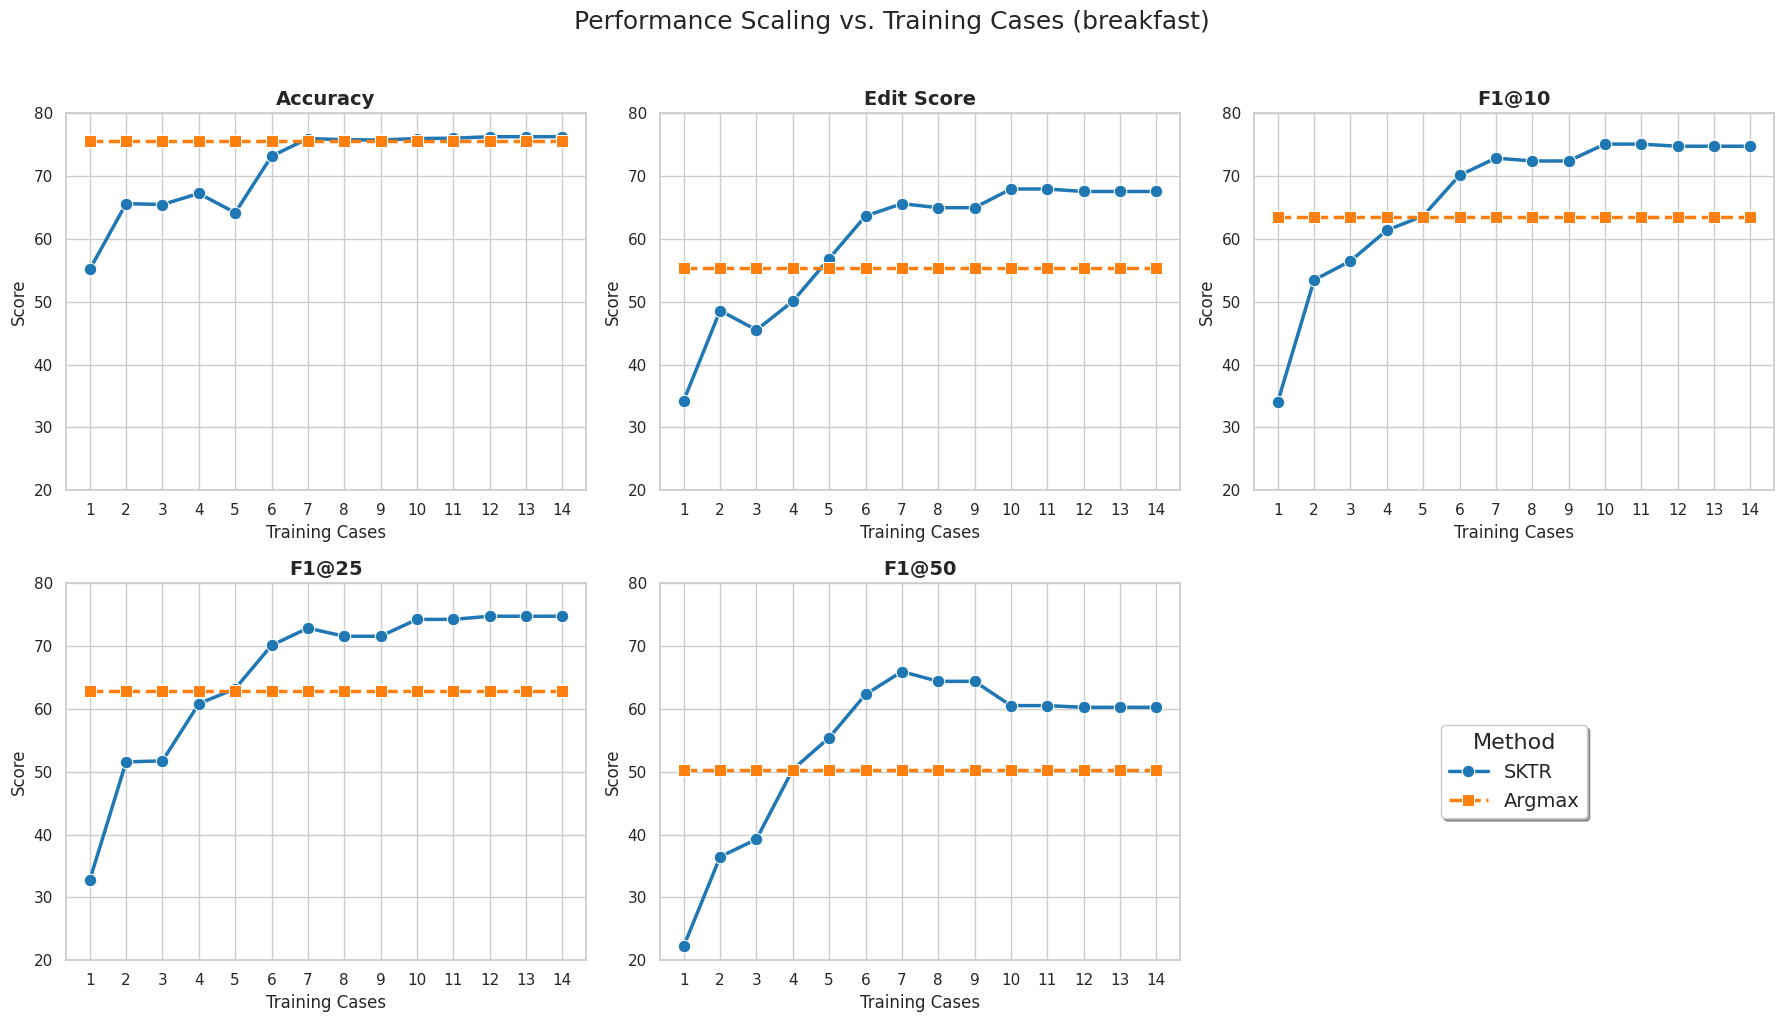

In [17]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid', context='notebook', palette='deep')

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

metrics_config = [
    ('acc', 'Accuracy'),
    ('edit', 'Edit Score'),
    ('f1@10', 'F1@10'),
    ('f1@25', 'F1@25'),
    ('f1@50', 'F1@50'),
]

method_styles = {
    'sktr':   {'color': '#1f77b4', 'marker': 'o', 'label': 'SKTR',   'linestyle': '-'},
    'argmax': {'color': '#ff7f0e', 'marker': 's', 'label': 'Argmax', 'linestyle': '--'},
}

plot_cols = []
for metric_suffix, _ in metrics_config:
    for method in method_styles:
        col_name = f'{method}_{metric_suffix}'
        if col_name in df.columns:
            plot_cols.append(col_name)

y_limits = None
y_ticks = None
if plot_cols:
    y_min = df[plot_cols].min().min()
    y_max = df[plot_cols].max().max()
    y_lower = math.floor(y_min / 10) * 10
    y_max = max(y_max, 80)
    tick_start = y_lower
    tick_end = math.ceil(y_max / 10) * 10
    y_limits = (tick_start, tick_end)
    y_ticks = list(range(int(tick_start), int(tick_end) + 1, 10))

for idx, (metric_suffix, title) in enumerate(metrics_config):
    ax = axes[idx]
    for method, style in method_styles.items():
        col_name = f'{method}_{metric_suffix}'
        if col_name in df.columns:
            sns.lineplot(
                x=df['n_train'],
                y=df[col_name],
                ax=ax,
                linewidth=2.5,
                markersize=9,
                **style,
            )
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Training Cases')
    ax.set_ylabel('Score')
    ax.set_xticks(df['n_train'].unique())
    if y_limits is not None:
        ax.set_ylim(*y_limits)
    if y_ticks is not None:
        ax.set_yticks(y_ticks)
    ax.legend().remove()

ax_legend = axes[5]
ax_legend.axis('off')
handles, labels = axes[0].get_legend_handles_labels()
ax_legend.legend(
    handles,
    labels,
    loc='center',
    title='Method',
    fontsize=14,
    title_fontsize=16,
    frameon=True,
    fancybox=True,
    shadow=True,
)

plt.suptitle(f'Performance Scaling vs. Training Cases ({dataset_name})', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()
